- creer le predicteur pour chacun des timeframes (30mn - 1H - 4H - 1D/ repertoires stephane_fresh
- utiliser le modele pour predire un max de perte qui soit 2 fois inferieur au profit.
- A chaque fin de chandelle (4h ou 1h) , faire une prediction pour :
- si la chandelle qui se termine est negative (cad close<open) :
  - probabilite que le LOW de la prochaine chandelle soit au moins 20 points plus bas que le CLOSE de la chandelle qui s'est terminee.
  - probabilite que le HIGH del la prochaine chandelle soit maximum 18 pips au dessus du CLOSE
- si la chandelle qui se termine est positive (cad open<close) :
  - probabilite que le HIGH de la prochaine chandelle soit au moins 20 points plus haut que le CLOSE de la chandelle qui s'est terminee.
  - probabilite que le LOW soit max 18 pips en dessous du CLOSE


In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from datetime import datetime, timedelta
from service import files_service
from model.models import TradeModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set folder for data

In [43]:
PATH = "data/test_all_periods/"

#### Read data and convert to TradeModel

In [44]:
files = files_service.get_files(PATH,extension='.csv')

In [45]:
files
files = [files[2]]

In [46]:
TradeModel_dict={}
for f in files:
    name = f.split('.csv')[0]
    frequency =  '\"' + f.split('_')[2] + '\"'
    print name, frequency
    path = PATH+f
    tm = TradeModel(path,name,frequency=frequency)
    TradeModel_dict[name]= tm

EURUSD_UTC_4H_Bid_2010.01.01_2017.02.18 "4H"


In [47]:
tm =TradeModel_dict['EURUSD_UTC_4H_Bid_2010.01.01_2017.02.18']

In [48]:
tm.df.head(1)

,Open,High,Low,Close,Volume,KC_M_1,KC_U_1,KC_D_1,KC_M_2,KC_U_2,...,cs_body_pos,cs_body_ratio,next_Low,next_High,next_Close,DOWN_next_Low_under_Close,DOWN_next_High_over_Close,UP_next_High_over_Close,UP_next_Low_under_Close,hour
date_time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 08:00:00,1.43297,1.43346,1.43218,1.43306,18182.8,NaN,NaN,NaN,NaN,NaN,...,1.433015,-0.000195,1.43207,1.43354,1.43337,0,0,0,0,8


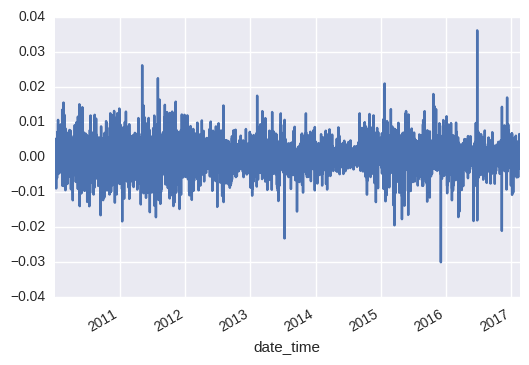

In [49]:
ax = tm.df.cs_body_size.plot()

In [50]:
tm.df[tm.df.cs_body_size>0][['DOWN_next_Low_under_Close','DOWN_next_High_over_Close']].apply(pd.Series.value_counts)


,DOWN_next_Low_under_Close,DOWN_next_High_over_Close
0,3674,5795
1,2132,11


In [51]:
tm.df[tm.df.cs_body_size<0][['UP_next_High_over_Close','UP_next_Low_under_Close']].apply(pd.Series.value_counts)


,UP_next_High_over_Close,UP_next_Low_under_Close
0,3602,3433
1,2074,2243


In [52]:
tm.df.to_csv('tradeModel_data.csv')

In [53]:
def train_test_split(df, date, target):
              
    predictors =tm.get_predictors_columns()
    #predictors =['Open','High','Low','High','KC_M_3','KC_U_3','ATR','EMA12','EMA30']

    df_train = df[df.index<date]
    df_test = df[df.index==date]
    
    tm.X_train,tm.y_train = df_train[predictors].values,df_train[target].values
    tm.X_test, tm.y_test  = df_test[predictors].values,df_test[target].values  
    

In [54]:
def cv_optimize(clf,  tm,parameters={}, n_folds=5):
    
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=-1)
    gs.fit(tm.X_train, tm.y_train)
    
    return gs.best_estimator_    

In [55]:
def predict_next(tm,target,clf, parameters={}):
    
    best_clf = cv_optimize(clf,tm, parameters)
   
    prediction =  best_clf.predict_proba(tm.X_test)
    
    return prediction

In [56]:
def compute_prediction(trade_model,target,last_index,clf=None):
    
    if clf is None:
        clf = xgb.XGBClassifier(max_depth=12,n_estimators=300)
    prediction = []
    
    #df = tm.filter_on_trend(target)

    df = tm.df.copy()
    
    df = df.dropna()
    
    for dt in df.tail(last_index).index:
        print dt
       
        train_test_split(df,dt,target)
        predictions = predict_next(tm,target,clf)
        prediction.append((dt,tm.y_test[0],predictions[0][0],predictions[0][1]))
    df_result =  pd.DataFrame(prediction,columns=['date','observed',target+'_FALSE', target+'_TRUE'])
    pickle.dump(df_result, open('data/'+trade_model.name+'_'+target+'.p', "wb"))
    
    return df_result

In [57]:
TARGETS = ['DOWN_next_Low_under_Close','DOWN_next_High_over_Close','UP_next_High_over_Close','UP_next_Low_under_Close']

In [71]:
def compute_all_predictions(trade_model,last_index=100,clf=None):
    for target in TARGETS:
        predictions = compute_prediction(tm,target,last_index,clf=ExtraTreeClassifier())
        #!!!!!!!!!!!!!!!!!!!!!!!!!!
        break
        #!!!!!!!!!!!!!!!!!!!!!!

In [72]:
compute_all_predictions(tm)

2017-01-26 16:00:00
2017-01-26 20:00:00
2017-01-27 00:00:00
2017-01-27 04:00:00
2017-01-27 08:00:00
2017-01-27 12:00:00
2017-01-27 16:00:00
2017-01-27 20:00:00
2017-01-29 20:00:00
2017-01-30 00:00:00
2017-01-30 04:00:00
2017-01-30 08:00:00
2017-01-30 12:00:00
2017-01-30 16:00:00
2017-01-30 20:00:00
2017-01-31 00:00:00
2017-01-31 04:00:00
2017-01-31 08:00:00
2017-01-31 12:00:00
2017-01-31 16:00:00
2017-01-31 20:00:00
2017-02-01 00:00:00
2017-02-01 04:00:00
2017-02-01 08:00:00
2017-02-01 12:00:00
2017-02-01 16:00:00
2017-02-01 20:00:00
2017-02-02 00:00:00
2017-02-02 04:00:00
2017-02-02 08:00:00
2017-02-02 12:00:00
2017-02-02 16:00:00
2017-02-02 20:00:00
2017-02-03 00:00:00
2017-02-03 04:00:00
2017-02-03 08:00:00
2017-02-03 12:00:00
2017-02-03 16:00:00
2017-02-03 20:00:00
2017-02-05 20:00:00
2017-02-06 00:00:00
2017-02-06 04:00:00
2017-02-06 08:00:00
2017-02-06 12:00:00
2017-02-06 16:00:00
2017-02-06 20:00:00
2017-02-07 00:00:00
2017-02-07 04:00:00
2017-02-07 08:00:00
2017-02-07 12:00:00


In [73]:
def load_predictions(tm_name):
    predictions_dict={}
    files = files_service.get_files('data/',extension='.p',filter_on=tm_name)
    for f in files:
        
        prediction_df = pickle.load(open('data/'+f, "rb"))
        predictions_dict[f.split(tm_name)[1]]=prediction_df
        
    return predictions_dict

In [74]:
dico_pred = load_predictions('EURUSD_UTC_4H_Bid_2010.01.01_2017.02.18')


In [75]:
df_test =dico_pred['_DOWN_next_Low_under_Close.p']
df_test.head()

,date,observed,DOWN_next_Low_under_Close_FALSE,DOWN_next_Low_under_Close_TRUE
0,2017-01-26 16:00:00,1,1.0,0.0
1,2017-01-26 20:00:00,0,1.0,0.0
2,2017-01-27 00:00:00,0,1.0,0.0
3,2017-01-27 04:00:00,0,1.0,0.0
4,2017-01-27 08:00:00,1,0.0,1.0


In [76]:
df_test['predicted'] =( df_test.DOWN_next_Low_under_Close_TRUE>.5)*1

In [77]:
df_test['result_OK']= np.where(df_test.predicted==df_test.observed,1,0)

In [78]:
df_test =df_test.sort_values(by='DOWN_next_Low_under_Close_FALSE')

#### Baseline

In [79]:
df_test[df_test.observed==1]

,date,observed,DOWN_next_Low_under_Close_FALSE,DOWN_next_Low_under_Close_TRUE,predicted,result_OK
36,2017-02-03 12:00:00,1,0.0,1.0,1,1
40,2017-02-06 00:00:00,1,0.0,1.0,1,1
69,2017-02-10 20:00:00,1,0.0,1.0,1,1
79,2017-02-14 08:00:00,1,0.0,1.0,1,1
47,2017-02-07 04:00:00,1,0.0,1.0,1,1
50,2017-02-07 16:00:00,1,0.0,1.0,1,1
52,2017-02-08 00:00:00,1,0.0,1.0,1,1
55,2017-02-08 12:00:00,1,0.0,1.0,1,1
46,2017-02-07 00:00:00,1,0.0,1.0,1,1
11,2017-01-30 08:00:00,1,0.0,1.0,1,1


In [80]:
print df_test.observed.value_counts()
print 'accuracy baseline : {}%'.format(df_test.observed.value_counts()[0]*100.0/df_test.observed.count())

0    69
1    31
Name: observed, dtype: int64
accuracy baseline : 69.0%


####  Accuracy and Precision

In [81]:
df_test[df_test.predicted==1]

,date,observed,DOWN_next_Low_under_Close_FALSE,DOWN_next_Low_under_Close_TRUE,predicted,result_OK
49,2017-02-07 12:00:00,0,0.0,1.0,1,0
35,2017-02-03 08:00:00,0,0.0,1.0,1,0
36,2017-02-03 12:00:00,1,0.0,1.0,1,1
71,2017-02-13 00:00:00,0,0.0,1.0,1,0
70,2017-02-12 20:00:00,0,0.0,1.0,1,0
40,2017-02-06 00:00:00,1,0.0,1.0,1,1
69,2017-02-10 20:00:00,1,0.0,1.0,1,1
43,2017-02-06 12:00:00,0,0.0,1.0,1,0
79,2017-02-14 08:00:00,1,0.0,1.0,1,1
67,2017-02-10 12:00:00,0,0.0,1.0,1,0


In [82]:
accuracy = sum(df_test.result_OK)*100.0 /df_test.observed.count()
print 'Accuracy model : {} %'.format(accuracy)
#precision = TP/(FP+TP)
precision = np.sum((df_test.predicted==1) & (df_test.result_OK==1)) *100.0 /np.sum(df_test.predicted==1)


print 'Precision model : {} %'.format(precision)

Accuracy model : 63.0 %
Precision model : 40.0 %


In [83]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=50, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax